## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## Load the Data

In [2]:
df = pd.read_csv(r"C:\Users\Yasserkm\Desktop\Bootcamp-V8\Usecases\Usecase-4\data\data_saudi_used_cars.csv")

In [3]:
df.shape

(5624, 11)

In [4]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [5]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price


In [6]:
# Completeness
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [7]:
# Accurecy types
df.dtypes

Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [8]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
numeric_features = ['Year', 'Engine_Size', 'Mileage']

In [9]:
# for i in categorical_features:
#     print (df[i].value_counts())

In [10]:
df = df[df['Year']>=2000]

In [11]:
# Calculate the frequency of each 'Type'
type_counts = df['Type'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Type'].isin(type_counts[type_counts >= 2].index)]

In [12]:
df.shape

(5364, 11)

In [13]:
# Calculate the frequency of each 'Make'
make_counts = df['Make'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Make'].isin(make_counts[make_counts >=2].index)]

In [14]:
df.shape

(5364, 11)

In [15]:
#df[df['Type']=='Other']

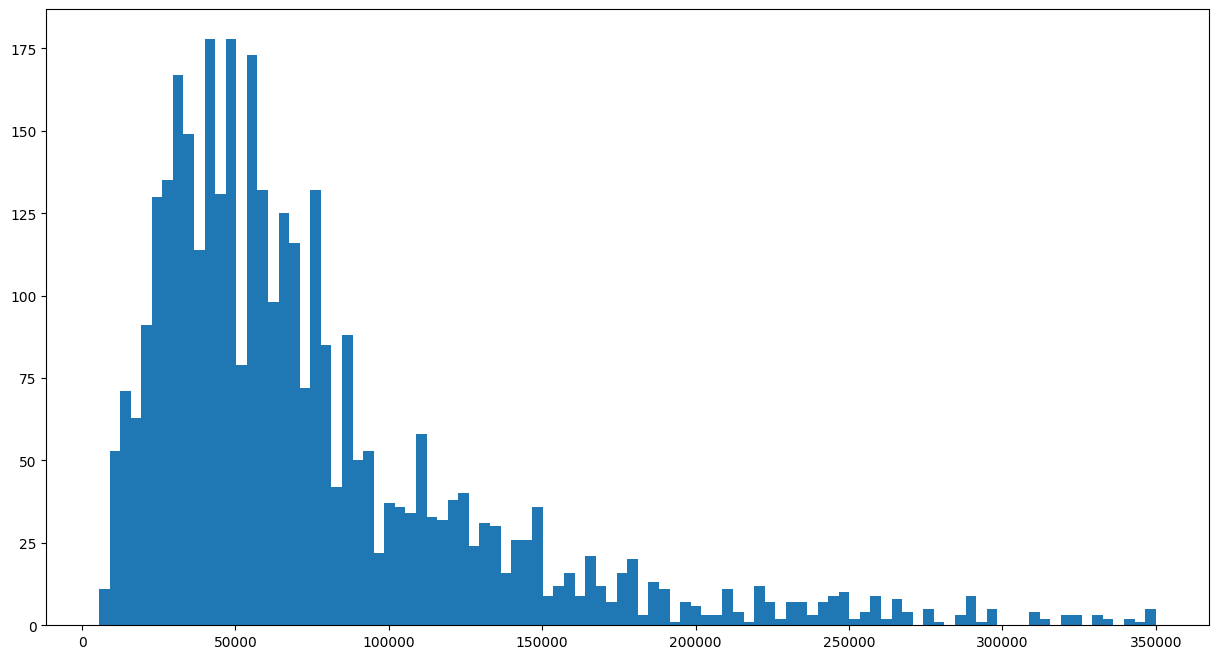

In [16]:
plt.figure(figsize=(15,8))
# plt.boxplot(df['Price']);
plt.hist(df[(df['Price']<=350000) & (df['Price']>5000)]['Price'], bins=100);
#plt.hist(df[(df['Price']<=400000) & (df['Price']>=5000)]['Price'], bins=100);

In [17]:
df = df[(df['Price']<=350000) & (df['Price']>=5000)]

In [18]:
df.shape

(3566, 11)

In [19]:
#df[df['Mileage']<1000]

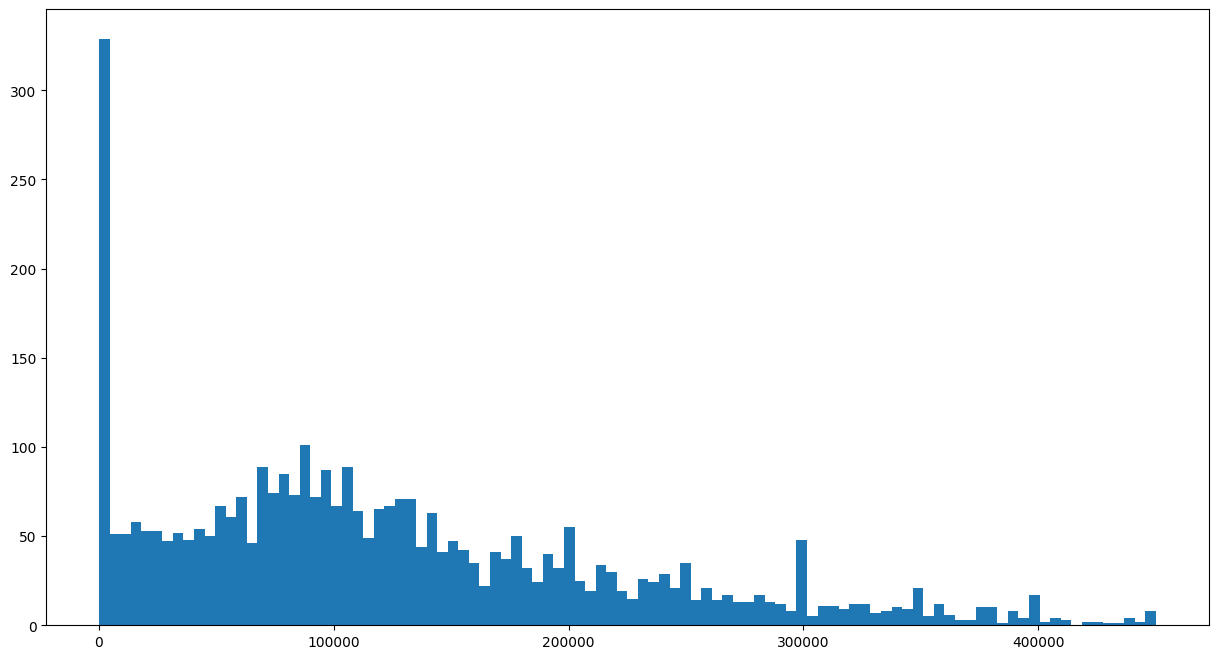

In [20]:
plt.figure(figsize=(15,8))
#plt.boxplot(df['Mileage']);
plt.hist(df[df['Mileage']<=450000]['Mileage'], bins=100);
#plt.hist(df['Mileage'], bins=100);

In [21]:
df = df[df['Mileage']<=450000]
df.shape

(3511, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [22]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000


In [23]:
categorical_features

['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']

In [24]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [25]:
df.shape

(3511, 325)

In [26]:
df.head(2)

,Year,Engine_Size,Mileage,Negotiable,Price,Type_3,Type_300,Type_3008,Type_301,Type_5,...,Make_Zhengzhou,Gear_Type_Automatic,Gear_Type_Manual,Origin_Gulf Arabic,Origin_Other,Origin_Saudi,Origin_Unknown,Options_Full,Options_Semi Full,Options_Standard
1,2014,8.0,80000,False,120000,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,False
2,2015,5.0,140000,False,260000,False,False,False,False,False,...,False,True,False,True,False,False,False,True,False,False


#### 3. Feature selection

In [27]:
# sns.heatmap(df.corr(), annot=True);

In [28]:
correlation = df.corr()
print(correlation['Price'].sort_values(ascending=False))

Price               1.000000
Year                0.383150
Options_Full        0.335431
Engine_Size         0.327441
Make_Mercedes       0.298269
                      ...   
Origin_Saudi       -0.181963
Make_Hyundai       -0.206750
Options_Standard   -0.278682
Mileage            -0.301282
Negotiable               NaN
Name: Price, Length: 325, dtype: float64


In [29]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['Price']) > threshold]['Price'].index
selected_features

Index(['Year', 'Engine_Size', 'Mileage', 'Price', 'Type_Land Cruiser',
       'Type_Range Rover', 'Make_Hyundai', 'Make_Land Rover', 'Make_Lexus',
       'Make_Mercedes', 'Options_Full', 'Options_Standard'],
      dtype='object')

In [30]:
selected_features = ['Year', 'Engine_Size', 'Mileage', 'Price', 'Type_Land Cruiser',
       'Type_Range Rover', 'Make_Hyundai', 'Make_Land Rover', 'Make_Lexus',
       'Make_Mercedes', 'Options_Full', 'Options_Standard']

In [31]:
df = df[selected_features]
df.head()

,Year,Engine_Size,Mileage,Price,Type_Land Cruiser,Type_Range Rover,Make_Hyundai,Make_Land Rover,Make_Lexus,Make_Mercedes,Options_Full,Options_Standard
1,2014,8.0,80000,120000,False,False,False,False,False,False,True,False
2,2015,5.0,140000,260000,False,True,False,True,False,False,True,False
3,2015,2.4,220000,42000,False,False,False,False,False,False,False,False
5,2019,2.0,25000,58000,False,False,False,False,False,False,False,False
6,2012,4.8,189000,85000,False,False,False,False,False,False,True,False


#### 4. Prepare train and test data

In [32]:
# Prepare data
X = df.drop(['Price'], axis=1)
y = df['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
X.shape

(3511, 11)

## Buliding the Model

In [34]:
model = LinearRegression()

In [35]:
ridge_model = Ridge()  # You can adjust alpha to see different resu

In [36]:
lasso_model = Lasso()  # You can adjust alpha to see different results

In [37]:
param_grid = {
    'alpha': [0, 0.003, 0.0002, 0.001, 0.01, 0.5, 1, 5]  # Regularization strength
}
grid_search_ridge = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=lasso_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

## Train the Model

In [38]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

In [39]:
# Fit GridSearchCV on the training data
grid_search_ridge.fit(X_train_scaled, y_train)
grid_search_lasso.fit(X_train_scaled, y_train)

# Get the best parameters and best model

# Ridge
best_params_ridge = grid_search_ridge.best_params_
best_model_ridge = grid_search_ridge.best_estimator_

# Lasso
best_params_lasso = grid_search_lasso.best_params_
best_model_lasso = grid_search_lasso.best_estimator_

print("Best Parameters for ridge model:", best_params_ridge)
print("Best Parameters for lasso model:", best_params_lasso)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for ridge model: {'alpha': 5}
Best Parameters for lasso model: {'alpha': 5}


## Test the Model

In [40]:
# Predict and evaluate the model

y_pred = model.predict(X_test_scaled)                  # Linear regression model
y_pred_ridge = best_model_ridge.predict(X_test_scaled) # Ridge model
y_pred_lasso = best_model_lasso.predict(X_test_scaled) # Lasso model

## Interpretation of the Model

In [41]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])                  # Linear model cofficients
coeff_df_ridge = pd.DataFrame(best_model_ridge.coef_,X.columns,columns=['Coefficient']) # Ridge model cofficients
coeff_df_lasso = pd.DataFrame(best_model_lasso.coef_,X.columns,columns=['Coefficient']) # Lasso model cofficients


In [42]:
coeff_df

,Coefficient
Year,28224.620315
Engine_Size,19346.024974
Mileage,-6025.474951
Type_Land Cruiser,13666.001992
Type_Range Rover,-6952.403985
Make_Hyundai,-5871.846539
Make_Land Rover,17125.092704
Make_Lexus,10935.792250
Make_Mercedes,16204.082779
Options_Full,6130.145363


In [43]:
coeff_df_ridge

,Coefficient
Year,28148.905777
Engine_Size,19290.337065
Mileage,-6050.802485
Type_Land Cruiser,13644.370662
Type_Range Rover,-5542.505278
Make_Hyundai,-5872.240451
Make_Land Rover,15705.390392
Make_Lexus,10915.561952
Make_Mercedes,16167.699748
Options_Full,6135.947727


In [76]:
coeff_df_lasso

,Coefficient
Year,28218.614887
Engine_Size,19339.828547
Mileage,-6024.011475
Type_Land Cruiser,13661.660996
Type_Range Rover,-6575.277270
Make_Hyundai,-5869.061000
Make_Land Rover,16748.338277
Make_Lexus,10931.232121
Make_Mercedes,16198.969185
Options_Full,6130.224700


In [73]:
print(f" Linear regression intercept: {model.intercept_}") 

 Linear regression intercept: 75439.30021367458


In [74]:
print(f" Ridge model intercept: {best_model_ridge.intercept_}") 

 Ridge model intercept: 75439.30021367458


In [75]:
print(f" Lasso model intercept: {best_model_lasso.intercept_}") 

 Lasso model intercept: 75439.30021367458


## Evaluating the Model 

1. Mean Square Error

In [72]:
y_base = [y_train.mean()] * len(y_test)

In [68]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base:2e}')

Mean Squared Error of base model: 3.525053e+09


In [69]:
# MSE for Linear model
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train:2e}')
print(f'Mean Squared Error for testing: {mse_test:2e}')


Mean Squared Error for training: 1.130468e+09
Mean Squared Error for testing: 1.091273e+09


In [70]:
# MSE for Ridge model
mse_train_ridge = mean_squared_error(y_train, best_model_ridge.predict(X_train_scaled))
mse_test_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f'Mean Squared Error for training ridge model: {mse_train_ridge:2e}')
print(f'Mean Squared Error for testing ridge model: {mse_test_ridge:2e}')


Mean Squared Error for training ridge model: 1.130529e+09
Mean Squared Error for testing ridge model: 1.091817e+09


In [71]:
# MSE Lasso model
mse_train_lasso = mean_squared_error(y_train, best_model_lasso.predict(X_train_scaled))
mse_test_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'Mean Squared Error for training lasso model: {mse_train_lasso:2e}')
print(f'Mean Squared Error for testing lasso model: {mse_test_lasso:2e}')

Mean Squared Error for training lasso model: 1.130472e+09
Mean Squared Error for testing lasso model: 1.091289e+09


2. Mean Absolute Error

In [67]:
# our benchmark model
mae_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mae_base:2e}')

Mean Absolute  Error of base model: 4.220097e+04


In [64]:
# Linear model
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train:2e}')
print(f'Mean Absolute Error for testing: {mae_test:2e}')

Mean Absolute Error for training: 2.274692e+04
Mean Absolute Error for testing: 2.296329e+04


In [65]:
# MSE for Ridge model
mae_train_ridge = mean_absolute_error(y_train, best_model_ridge.predict(X_train_scaled))
mae_test_ridge = mean_absolute_error(y_test, y_pred_ridge)
print(f'Mean Absolute Error for training ridge model: {mae_train_ridge:2e}')
print(f'Mean Absolute Error for testing ridge model: {mae_test_ridge:2e}')

Mean Absolute Error for training ridge model: 2.275048e+04
Mean Absolute Error for testing ridge model: 2.296829e+04


In [66]:
# Lasso model
mae_train_lasso = mean_absolute_error(y_train, best_model_lasso.predict(X_train_scaled))
mae_test_lasso = mean_absolute_error(y_test, y_pred_lasso)
print(f'Mean Absolute Error for training lasso model: {mae_train_lasso:2e}')
print(f'Mean Absolute Error for testing lasso model: {mae_test_lasso:2e}')

Mean Absolute Error for training lasso model: 2.274763e+04
Mean Absolute Error for testing lasso model: 2.296330e+04


3. Root Mean Squared Error

In [63]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base):2e}')

Root Mean Squared  Error of base model: 5.937216e+04


In [60]:
# RMSE for Linear model

print(f'Root Mean Squared Error for training: {np.sqrt(mse_train):2e}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test):2e}')

Root Mean Squared Error for training: 3.362243e+04
Root Mean Squared Error for testing: 3.303442e+04


In [61]:
# RMSE for Ridge model

print(f'Root Mean Squared Error for training ridge model: {np.sqrt(mse_train_ridge):2e}')
print(f'Root Mean Squared Error for testing ridge model: {np.sqrt(mse_test_ridge):2e}')


Root Mean Squared Error for training ridge model: 3.362334e+04
Root Mean Squared Error for testing ridge model: 3.304266e+04


In [62]:
# RMSE Lasso model

print(f'Root Mean Squared Error for training lasso model: {np.sqrt(mse_train_lasso):2e}')
print(f'Root Mean Squared Error for testing lasso model: {np.sqrt(mse_test_lasso):2e}')

Root Mean Squared Error for training lasso model: 3.362249e+04
Root Mean Squared Error for testing lasso model: 3.303466e+04


4. R Square

In [57]:
# Linear model r2 score
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.6471900447777357
R Square for testing: 0.6900400141480875


In [58]:
# Ridge model r2 score
r2_score_train_ridge = r2_score(y_train, best_model_ridge.predict(X_train_scaled))
r2_score_test_ridge = r2_score(y_test, y_pred_ridge)
print(f'R Square for training ridge model: {r2_score_train_ridge}')
print(f'R Square for testing ridge model: {r2_score_test_ridge}')

R Square for training ridge model: 0.6471710387253298
R Square for testing ridge model: 0.6898853830440681


In [59]:
# Lasso model r2 score
r2_score_train_lasso = r2_score(y_train, best_model_lasso.predict(X_train_scaled))
r2_score_test_lasso = r2_score(y_test, y_pred_lasso)
print(f'R Square for training lasso model: {r2_score_train_lasso}')
print(f'R Square for testing lasso model: {r2_score_test_lasso}')

R Square for training lasso model: 0.6471888043033047
R Square for testing lasso model: 0.6900354798823325


#### Predictions vs. Real Values

In [54]:
predictions = model.predict(X_test_scaled)
#predictions

In [55]:
Real_Values = np.array(y_test)
# Real_Values

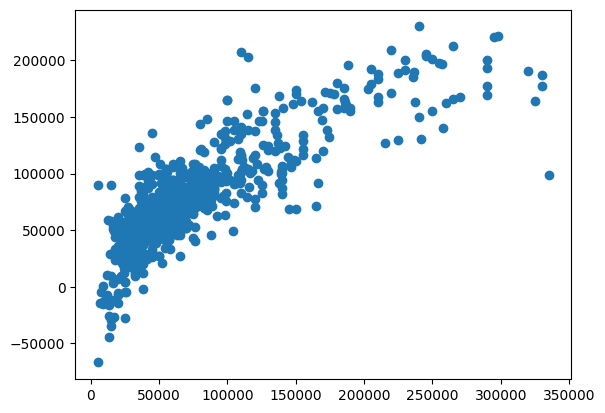

In [56]:
plt.scatter(Real_Values,predictions); 

#### Residual Histogram

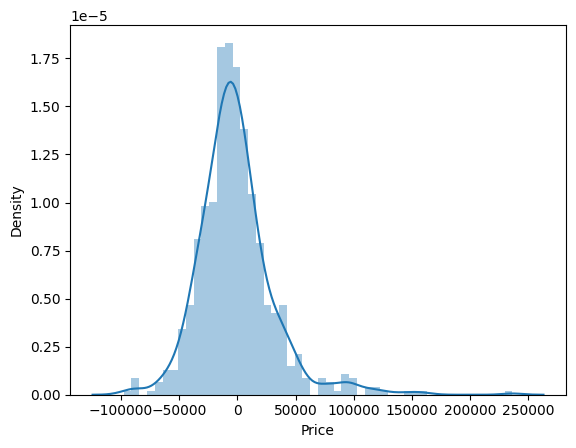

In [189]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution